In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz

In [3]:
#proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
proposal_probs = {"informed_grow": 0.25, "informed_prune": 0.25, 
                  "informed_change": 0.4, "informed_swap": 0.1}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.set_printoptions(suppress=True)
print(y_train[:12])

[ 0.50327821  0.60672224  0.26898966  0.55211673  0.50693811  0.66162097
 -0.64127659  0.65112284  0.03487759  0.23276531  0.44055996  0.38216964]


In [4]:
bart = InformedBART(ndpost=50, nskip=0, n_trees=100, proposal_probs=proposal_probs, informed_max_samples=10)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


In [8]:
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-06-08 02:51:46,016:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-08 02:51:46,018:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.36 A_prune=0.36 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.35 A_prune=0.37
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.39 A_prune=0.40


In [9]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.02323416657795812,
 'rf': 0.022139023845392215,
 'lr': 0.048045521328019404,
 'btz': 0.02328283761397566}

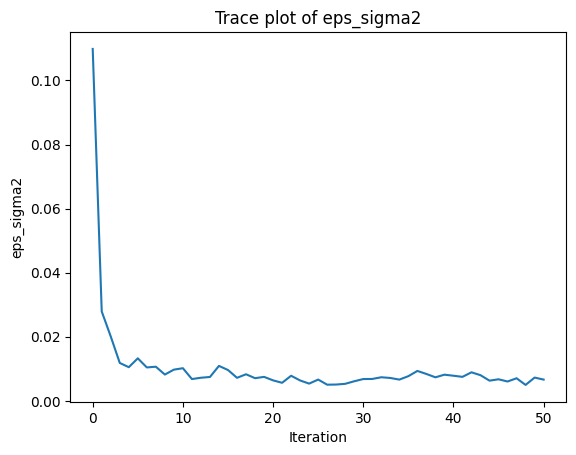

In [14]:
import matplotlib.pyplot as plt

sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
plt.plot(sigmas)
plt.title("Trace plot of eps_sigma2")
plt.xlabel("Iteration")
plt.ylabel("eps_sigma2")
plt.show()

## Default BART

In [15]:
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.set_printoptions(suppress=True)
print(y_train[:12])

[ 0.50327821  0.60672224  0.26898966  0.55211673  0.50693811  0.66162097
 -0.64127659  0.65112284  0.03487759  0.23276531  0.44055996  0.38216964]


In [16]:
bart = DefaultBART(ndpost=50, nskip=0, n_trees=100, proposal_probs=proposal_probs)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 50/50 [00:01<00:00, 29.72it/s]


In [17]:
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.36 A_prune=0.36 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.35 A_prune=0.37
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.39 A_prune=0.40


In [18]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.023677263271048504,
 'rf': 0.022139023845392215,
 'lr': 0.048045521328019404,
 'btz': 0.02328283761397566}

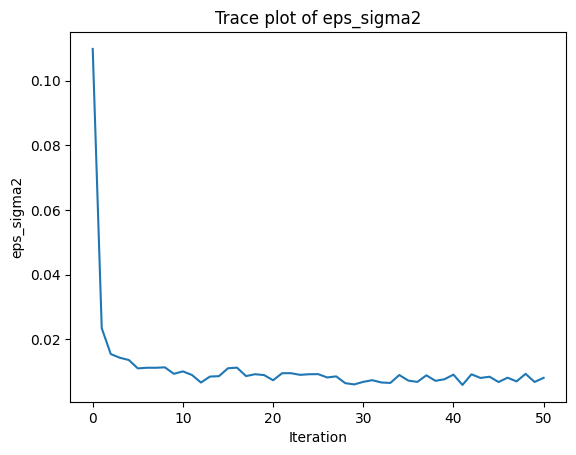

In [19]:
import matplotlib.pyplot as plt

sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
plt.plot(sigmas)
plt.title("Trace plot of eps_sigma2")
plt.xlabel("Iteration")
plt.ylabel("eps_sigma2")
plt.show()